# 0. Setup

In [33]:
# Import Packages
import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import shapely
from shapely import wkt
import statistics
import matplotlib.pyplot as plt
import zipfile

# Import sklearn modelling packages
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Import performance metrics
from sklearn.metrics import (mean_absolute_error as mae, mean_squared_error as mse, 
                             explained_variance_score as evs, r2_score as r2)                # Regression
from sklearn.metrics import (accuracy_score as acc, balanced_accuracy_score as bal_acc, 
                             f1_score as f1, roc_auc_score as roc_auc,
                             average_precision_score as ave_prec)                            # Classification
def mape(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [3]:
# Ignore Warnings
import warnings

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Assumptions
rs=42

sd_thresh = 1

# 1. Import and split data

## 1.1 Import

In [5]:
# Import Data
data_11 = pd.read_csv('C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\ML Gentrification Prediction\\Inputs\\Cleaned Dataset/Data_11_SEIFA_FINAL_GH.csv')
data_16 = pd.read_csv('C:\\Users\\wthac\\Desktop\\Value Australia\\Data\\ML Gentrification Prediction\\Inputs\\Cleaned Dataset/Data_16_SEIFA_FINAL_GH.csv')

## 1.2 Data split (80/20 ratio)

In [6]:
# Split data into training/test/validation
train, test = train_test_split(data_11, test_size = 0.2, random_state = rs)

# Split into X and Y
x_train = train.iloc[:,2:-14]  # Not including walkability metrics
y_train = train.iloc[:,-1]

x_test = test.iloc[:,2:-14]  # Not including walkability metrics
y_test = test.iloc[:,-1]

# 2. Build untuned GBM model

## 2.1 Fit basic GBM

In [8]:
# Import necessary packages
xgb = XGBRegressor(random_state=42)

In [9]:
# Fit basic RF model
xgb_model = xgb.fit(x_train, y_train)

# Fit prediction to test dataset
y_pred_xgb = xgb_model.predict(x_test)

## 2.2 Evaluate Performance - Based on SEIFA Score

In [10]:
# Calculate metrics
mae_xgb = mae(y_test, y_pred_xgb)
mse_xgb = mse(y_test, y_pred_xgb)
evs_xgb = evs(y_test, y_pred_xgb)
r2_xgb = r2(y_test, y_pred_xgb)
mape_xgb = mape(y_test, y_pred_xgb)

print(f"mae_xgb: {mae_xgb}, \nmse_xgb: {mse_xgb}, \nevs_xgb: {evs_xgb}, \nr2_xgb: {r2_xgb}, \nmape_xgb: {mape_xgb}")

mae_xgb: 21.290517478029646, 
mse_xgb: 867.0314724280549, 
evs_xgb: 0.9202270618232358, 
r2_xgb: 0.9202115983885921, 
mape_xgb: 2.1307590753470795


## 2.3 Evaluate Performance - Based on Predicted Rank

In [15]:
test_xgb = test

## Actual Rank Change
# Calculate the rank of each irsad_score within year
seq_11 = sorted(test_xgb['irsad_score_11'])
index_11 = [seq_11.index(v) for v in test_xgb['irsad_score_11']]

seq_16 = sorted(test_xgb['irsad_score_16'])
index_16 = [seq_16.index(v) for v in test_xgb['irsad_score_16']]

# Merge rank back onto main dataset
test_xgb['SEIFA_rank_11'] = index_11
test_xgb['SEIFA_rank_16'] = index_16

# Calculate change in rank:
test_xgb['SEIFA_rc_actual'] = test_xgb['SEIFA_rank_16'] - test_xgb['SEIFA_rank_11']


## xgb Predicted Rank Change
test_xgb['SEIFA_16_xgb'] = y_pred_xgb
seq_16_xgb = sorted(test_xgb['SEIFA_16_xgb'])
index_16_xgb = [seq_16_xgb.index(v) for v in test_xgb['SEIFA_16_xgb']]

# Merge rank back onto main dataset
test_xgb['SEIFA_rank_16_xgb'] = index_16_xgb

# Calculate change in rank:
test_xgb['SEIFA_rc_xgb'] = test_xgb['SEIFA_rank_16_xgb'] - test_xgb['SEIFA_rank_11']

In [16]:
# Create rank vectors
rank_test = test_xgb['SEIFA_rank_16']
rank_pred_xgb = test_xgb['SEIFA_rank_16_xgb']

# Calculate metrics
mae_xgb_rank = mae(rank_test, rank_pred_xgb)
mse_xgb_rank = mse(rank_test, rank_pred_xgb)
evs_xgb_rank = evs(rank_test, rank_pred_xgb)
r2_xgb_rank = r2(rank_test, rank_pred_xgb)
mape_xgb_rank = mape(rank_test, rank_pred_xgb)

print(f"mae_xgb_rank: {mae_xgb_rank}, \nmse_xgb_rank: {mse_xgb_rank}, \nevs_xgb_rank: {evs_xgb_rank}, \
      \nr2_xgb_rank: {r2_xgb_rank}, \nmape_xgb_rank: {mape_xgb_rank}")

mae_xgb_rank: 123.36286522148916, 
mse_xgb_rank: 29729.003770028274, 
evs_xgb_rank: 0.9206490636481404,       
r2_xgb_rank: 0.920624395567501, 
mape_xgb_rank: 21.256084261722677


## 2.4 Evaluate Performance - Based on Gentrification Flag

*Gentrification

In [17]:
# Calculate standard deviation of rank change
sd_rc = statistics.stdev(test_xgb['SEIFA_rc_actual'])
sd_rc_xgb = statistics.stdev(test_xgb['SEIFA_rc_xgb'])

# Create new column flagging gentrification
test_xgb['gentrification_flag'] = np.where(test_xgb['SEIFA_rc_actual'] > sd_thresh * sd_rc, 1, 0)
test_xgb['gentrification_flag_xgb'] = np.where(test_xgb['SEIFA_rc_xgb'] > sd_thresh * sd_rc_xgb, 1, 0)

In [18]:
# Define actual and predicted vectors
gent_test = test_xgb['gentrification_flag']
gent_pred_xgb = test_xgb['gentrification_flag_xgb']

# Calculate classification pexgbormance scores
acc_xgb_gent = acc(gent_test, gent_pred_xgb)
bal_acc_xgb_gent = bal_acc(gent_test, gent_pred_xgb)
f1_xgb_gent = f1(gent_test, gent_pred_xgb)
roc_auc_xgb_gent = roc_auc(gent_test, gent_pred_xgb)
ave_prec_xgb_gent = ave_prec(gent_test, gent_pred_xgb)

print(f"acc_xgb_gent: {acc_xgb_gent}, \nbal_acc_xgb_gent: {bal_acc_xgb_gent}, \nf1_xgb_gent: {f1_xgb_gent}, \
      \nroc_auc_xgb_gent: {roc_auc_xgb_gent}, \nave_prec_xgb_gent: {ave_prec_xgb_gent}")

acc_xgb_gent: 0.8647502356267672, 
bal_acc_xgb_gent: 0.7281987858736871, 
f1_xgb_gent: 0.5127334465195246,       
roc_auc_xgb_gent: 0.7281987858736871, 
ave_prec_xgb_gent: 0.3235726252725632


# 3. Hyperparameter tuning

Now I will be performing the hyperparameter tuning of the GBM model. The hyperparameters that I will tune include:

Tree-Based Parameters:

- max_depth
- min_child_weight (defines minimum sum of weights of all observations required in a child, high values -> reduces overfitting)
- gamma (specifies minimum loss reduction to make a split)
- subsample (denotes the fraction of observations to be randomly samples for each tree, lower values -> less overfitting)
- colsample_bytree (similar to max_features in GBM; denotes fraction of columns to be randomly samples for each tree)

Regularisation Parameters:

- lambda (L2 regularisation weight; analogous to Ridge regression)
- alpha (L1 regularisation weight; analogous to Lasso regression)

Boosting parameters

- n_trees
- learning_rate

I will take the following general approach to tuning:

1. Choose a relatively high learning rate. Generally the default value of 0.1 works - this will be changed later in the process, because generally speaking a lower learning rate will always improve the model (given sufficient trees), however will make the calculations more computationally expensive. Determine the optimum number of trees for this learning rate.
2. Tune tree-specific parameters for decided learning rate and number of trees. Note that we can choose different parameters to define a tree.
3. Tune regularisation parameters for xgboost which can help reduce model complexity and enhance learning performance
4. Lower the learning rate and increase the n_trees proportionally to get more robust models.

## 3.1 Tune optimum number of trees using GridSearchCV()

In order to tune optimum number of trees, we need to first fix the learning rate and tree-based parameters. Therefore, I will fix:

- Learning rate = 0. ---- NOTE: Initially chose 0.1, however tuned n_estimators was very high - meaning tuning other paramaters would be too timely, therefore increase learning rate for now, and will lower learning rate later
- Max depth = 5
- Min child weight = 3
- Gamma = 0
- Subsample, Column sample by tree = 0.8
- n_estimators = 1000

### 3.1.1 Define function to perform xgboost cross-validation

In [38]:
def modelfit(alg, x_train, y_train,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train, y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(x_train, y_train, eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(x_train)
        
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % mse(y_train, dtrain_predictions))
    print("R^2 Score (Train): %f" % r2(y_train, dtrain_predictions))

### 3.1.2 Tune optimum number of trees

In [48]:
# Define n_estimators space:
n_estimators = np.arange(20, 201, 20)

# Define fixed starting parameters
lr_t1 = 0.2
md_t1 = 5
mcw_t1 = 3
gam_t1 = 0
ss_t1 = 0.8
csbt_t1 = 0.8

# Create parameter grid
param_grid_t1 = dict(n_estimators = n_estimators)

# Create GBM model with fixed starting parameters
xgb_t1 = XGBRegressor(learning_rate = lr_t1, 
                      max_depth = md_t1,
                      min_child_weight = mcw_t1,
                      gamma = gam_t1,
                      subsample = ss_t1,
                      colsample_bytree = csbt_t1,
                      objective='reg:squarederror',
                      nthread = 4,
                      random_state=rs)

# Create Grid
grid_t1=GridSearchCV(estimator=xgb_t1, param_grid=param_grid_t1, cv=5)

In [49]:
grid_t1.fit(x_train, y_train)

print("The best n_estimators is %s with a score of %0.4f"
     % (grid_t1.best_params_, grid_t1.best_score_))

The best n_estimators is {'n_estimators': 120} with a score of 0.9286


## 3.2 Tune tree-specific parameters

The next steps is to choose the tree-based parameters using the decided n_estimators and learning_rate. I will tune the parameters separately so as to reduce calculation time.

### 3.2.1 Tune max_depth and min_child weight simultaneously

In [50]:
# Define max_depth and min_samples_split space:
max_depth = np.arange(5, 16, 2)
min_child_weight = np.arange(3, 10, 2)

# Define fixed starting parameters
lr_t2 = 0.2
ne_t2 = 120
#md_t2 = 5
#mcw_t2 = 3
gam_t2 = 0
ss_t2 = 0.8
csbt_t2 = 0.8

# Create parameter grid
param_grid_t2 = dict(max_depth = max_depth, 
                     min_child_weight = min_child_weight)

# Create XGB model with fixed starting parameters
xgb_t2 = XGBRegressor(learning_rate = lr_t2,
                      n_estimators = ne_t2,
#                      max_depth = md_t2,
#                      min_child_weight = mcw_t2,
                      gamma = gam_t2,
                      subsample = ss_t2,
                      colsample_bytree = csbt_t2,
                      objective='reg:squarederror',
                      nthread = 4,
                      random_state=rs)

grid_t2=GridSearchCV(estimator=xgb_t2, param_grid=param_grid_t2, cv=5)

In [51]:
grid_t2.fit(x_train, y_train)

print("The best parameters are %s with a score of %0.4f"
     % (grid_t2.best_params_, grid_t2.best_score_))

The best parameters are {'max_depth': 5, 'min_child_weight': 9} with a score of 0.9306


*Parameters are towards extreme values so I will retry grid*

In [53]:
# Define max_depth and min_samples_split space:
max_depth_b = [4, 5, 6]
min_child_weight_b = [8, 10, 12, 14]

# Create parameter grid
param_grid_t2b = dict(max_depth = max_depth_b,
                      min_child_weight = min_child_weight_b)

# Create XGB model with fixed starting parameters
xgb_t2b = XGBRegressor(learning_rate = lr_t2,
                      n_estimators = ne_t2,
#                      max_depth = md_t2,
#                      min_child_weight = mcw_t2,
                      gamma = gam_t2,
                      subsample = ss_t2,
                      colsample_bytree = csbt_t2,
                      objective='reg:squarederror',
                      nthread = 4,
                      random_state=rs)

grid_t2b=GridSearchCV(estimator=xgb_t2b, param_grid=param_grid_t2b, cv=5)

In [54]:
grid_t2b.fit(x_train, y_train)

print("The best parameters are %s with a score of %0.4f"
     % (grid_t2b.best_params_, grid_t2b.best_score_))

The best parameters are {'max_depth': 4, 'min_child_weight': 12} with a score of 0.9305


### 3.2.2 Tune gamma

In [56]:
# Define max_depth and min_samples_split space:
gamma = np.arange(0, 0.51, 0.05)

# Define fixed starting parameters
lr_t3 = 0.2
ne_t3 = 120
md_t3 = 4
mcw_t3 = 12
#gam_t3 = 0
ss_t3 = 0.8
csbt_t3 = 0.8

# Create parameter grid
param_grid_t3 = dict(gamma = gamma)

# Create XGB model with fixed starting parameters
xgb_t3 = XGBRegressor(learning_rate = lr_t3,
                      n_estimators = ne_t3,
                      max_depth = md_t3,
                      min_child_weight = mcw_t3,
#                      gamma = gam_t3,
                      subsample = ss_t3,
                      colsample_bytree = csbt_t3,
                      objective='reg:squarederror',
                      nthread = 4,
                      random_state=rs)

grid_t3=GridSearchCV(estimator=xgb_t3, param_grid=param_grid_t3, cv=5)

In [61]:
grid_t3.fit(x_train, y_train)

print("The best gamma is %s with a score of %0.4f"
     % (grid_t3.best_params_, grid_t3.best_score_))

The best gamma is {'gamma': 0.0} with a score of 0.9305


### 3.2.3 Tune subsample and colsample_bytree

In [62]:
# Define max_depth and min_samples_split space:
subsample = np.arange(0.6, 0.96, 0.05)
colsample_bytree = np.arange(0.6, 0.96, 0.05)

# Define fixed starting parameters
lr_t4 = 0.2
ne_t4 = 120
md_t4 = 4
mcw_t4 = 12
gam_t4 = 0
#ss_t4 = 0.8
#csbt_t4 = 0.8

# Create parameter grid
param_grid_t4 = dict(subsample = subsample,
                    colsample_bytree = colsample_bytree)

# Create XGB model with fixed starting parameters
xgb_t4 = XGBRegressor(learning_rate = lr_t4,
                      n_estimators = ne_t4,
                      max_depth = md_t4,
                      min_child_weight = mcw_t4,
                      gamma = gam_t4,
#                      subsample = ss_t4,
#                      colsample_bytree = csbt_t4,
                      objective='reg:squarederror',
                      nthread = 4,
                      random_state=rs)

grid_t4=GridSearchCV(estimator=xgb_t4, param_grid=param_grid_t4, cv=5)

In [63]:
grid_t4.fit(x_train, y_train)

print("The best parameters is %s with a score of %0.4f"
     % (grid_t4.best_params_, grid_t4.best_score_))

The best parameters is {'colsample_bytree': 0.7000000000000001, 'subsample': 0.9500000000000003} with a score of 0.9313


## 3.3 Tuning regularisation parameters

### 3.3.1 Tuning alpha

Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’.

In [64]:
# Define max_depth and min_samples_split space:
reg_alpha = [0.00001, 0.001, 0.1, 1, 100]

# Define fixed starting parameters
lr_t5 = 0.2
ne_t5 = 120
md_t5 = 4
mcw_t5 = 12
gam_t5 = 0
ss_t5 = 0.95
csbt_t5 = 0.7

# Create parameter grid
param_grid_t5 = dict(reg_alpha = alpha)

# Create XGB model with fixed starting parameters
xgb_t5 = XGBRegressor(learning_rate = lr_t5,
                      n_estimators = ne_t5,
                      max_depth = md_t5,
                      min_child_weight = mcw_t5,
                      gamma = gam_t5,
                      subsample = ss_t5,
                      colsample_bytree = csbt_t5,
                      objective='reg:squarederror',
                      nthread = 4,
                      random_state=rs)

grid_t5=GridSearchCV(estimator=xgb_t5, param_grid=param_grid_t5, cv=5)

In [65]:
grid_t5.fit(x_train, y_train)

print("The best alpha is %s with a score of %0.4f"
     % (grid_t5.best_params_, grid_t5.best_score_))

The best alpha is {'reg_alpha': 0.001} with a score of 0.9313


### 3.3.2 Tuning lambda

In [68]:
# Define max_depth and min_samples_split space:
reg_lambda = np.arange(0.5, 1.51, 0.1)

# Define fixed starting parameters
lr_t6 = 0.2
ne_t6 = 120
md_t6 = 4
mcw_t6 = 12
gam_t6 = 0
ss_t6 = 0.95
csbt_t6 = 0.7

# Create parameter grid
param_grid_t6 = dict(reg_lambda = reg_lambda)

# Create XGB model with fixed starting parameters
xgb_t6 = XGBRegressor(learning_rate = lr_t6,
                      n_estimators = ne_t6,
                      max_depth = md_t6,
                      min_child_weight = mcw_t6,
                      gamma = gam_t6,
                      subsample = ss_t6,
                      colsample_bytree = csbt_t6,
                      objective='reg:squarederror',
                      nthread = 4,
                      random_state=rs)

grid_t6=GridSearchCV(estimator=xgb_t6, param_grid=param_grid_t6, cv=5)

In [70]:
grid_t6.fit(x_train, y_train)

print("The best lambda is %s with a score of %0.4f"
     % (grid_t6.best_params_, grid_t6.best_score_))

The best lambda is {'reg_lambda': 0.6} with a score of 0.9314


### 3.3.4 Making models with lower learning rate

Now, we need to lower the learning rate and increase the number of estimators proportionally. 
I have taken the general approach of *halving* the learning rate and *doubling* the number of trees in each case.

As trees increase, it will become increasingly computationally expensive to perform CV and find the optimum values. 

In [72]:
# Define fixed starting parameters
md_tuned = 4
mcw_tuned = 12
gam_tuned = 0
ss_tuned = 0.95
csbt_tuned = 0.7
alp_tuned = 0.001
lam_tuned = 0.6

Reduce learning rate to **0.1** and increase n_estimators to **240**

In [73]:
# Define GBM model
xgb_tuned_lr1 = XGBRegressor(learning_rate = 0.1,
                             n_estimators = 240,
                             max_depth = md_tuned,
                             min_child_weight = mcw_tuned,
                             gamma = gam_tuned,
                             subsample = ss_tuned,
                             colsample_bytree = csbt_tuned,
                             reg_alpha = alp_tuned,
                             reg_lambda = lam_tuned,
                             objective='reg:squarederror',
                             nthread = 4,
                             random_state=rs)

# Calculate CV score
kfold=KFold(n_splits=5, random_state=rs)
results_lr1 = cross_val_score(xgb_tuned_lr1, x_train, y_train, cv=kfold)

# Calculate mean CV results
results_lr1.mean()

0.9337857355381963

Reduce learning rate to **0.05** and increase n_estimators to **480**

In [74]:
# Define GBM model
xgb_tuned_lr2 = XGBRegressor(learning_rate = 0.05,
                             n_estimators = 480,
                             max_depth = md_tuned,
                             min_child_weight = mcw_tuned,
                             gamma = gam_tuned,
                             subsample = ss_tuned,
                             colsample_bytree = csbt_tuned,
                             reg_alpha = alp_tuned,
                             reg_lambda = lam_tuned,
                             objective='reg:squarederror',
                             nthread = 4,
                             random_state=rs)

# Calculate CV score
kfold=KFold(n_splits=5, random_state=rs)
results_lr2 = cross_val_score(xgb_tuned_lr2, x_train, y_train, cv=kfold)

# Calculate mean CV results
results_lr2.mean()

0.9361695884151446

Reduce learning rate to **0.01** and increase n_estimators to **2400**

In [75]:
# Define GBM model
xgb_tuned_lr3 = XGBRegressor(learning_rate = 0.01,
                             n_estimators = 2400,
                             max_depth = md_tuned,
                             min_child_weight = mcw_tuned,
                             gamma = gam_tuned,
                             subsample = ss_tuned,
                             colsample_bytree = csbt_tuned,
                             reg_alpha = alp_tuned,
                             reg_lambda = lam_tuned,
                             objective='reg:squarederror',
                             nthread = 4,
                             random_state=rs)

# Calculate CV score
kfold=KFold(n_splits=5, random_state=rs)
results_lr3 = cross_val_score(xgb_tuned_lr3, x_train, y_train, cv=kfold)

# Calculate mean CV results
results_lr3.mean()

0.9371124889595499

## 3.4 Define best GBM model

In [77]:
# Run tuned model
xgb_tuned = XGBRegressor(learning_rate = 0.01,
                         n_estimators = 2400,
                         max_depth = md_tuned,
                         min_child_weight = mcw_tuned,
                         gamma = gam_tuned,
                         subsample = ss_tuned,
                         colsample_bytree = csbt_tuned,
                         reg_alpha = alp_tuned,
                         reg_lambda = lam_tuned,
                         objective='reg:squarederror',
                         nthread = 4,
                         random_state=rs)

# Fit RCV model
xgb_tuned_model = xgb_tuned.fit(x_train, y_train)

# Fit prediction to test dataset
y_pred_xgb_tuned = xgb_tuned_model.predict(x_test)

## 3.5 Evaluate Performance of tuned GBM

### 3.5.1 Performance based on SEIFA index

In [78]:
# Calculate metrics - SEIFA Score
mae_xgb_tuned = mae(y_test, y_pred_xgb_tuned)
mse_xgb_tuned = mse(y_test, y_pred_xgb_tuned)
evs_xgb_tuned = evs(y_test, y_pred_xgb_tuned)
r2_xgb_tuned = r2(y_test, y_pred_xgb_tuned)
mape_xgb_tuned = mape(y_test, y_pred_xgb_tuned)

print(f"mae_xgb_tuned: {mae_xgb_tuned}, \nmse_xgb_tuned: {mse_xgb_tuned}, \nevs_xgb_tuned: {evs_xgb_tuned}, \nr2_xgb_tuned: {r2_xgb_tuned}, \nmape_xgb_tuned: {mape_xgb_tuned}")

mae_xgb_tuned: 18.870173735623087, 
mse_xgb_tuned: 698.1312491052752, 
evs_xgb_tuned: 0.9357548468123797, 
r2_xgb_tuned: 0.9357546083937481, 
mape_xgb_tuned: 1.8849731918440389


### 3.5.2 Performance based on gentrification flag

*Gentrification*

In [79]:
## Calculate gentrification flag
test_xgb_tuned = test

# xgb_tuned Predicted Rank Change
test_xgb_tuned['SEIFA_16_xgb_tuned'] = y_pred_xgb_tuned
seq_16_xgb_tuned = sorted(test_xgb_tuned['SEIFA_16_xgb_tuned'])
index_16_xgb_tuned = [seq_16_xgb_tuned.index(v) for v in test_xgb_tuned['SEIFA_16_xgb_tuned']]

# Merge rank back onto main dataset
test_xgb_tuned['SEIFA_rank_16_xgb_tuned'] = index_16_xgb_tuned

# Calculate change in rank:
test_xgb_tuned['SEIFA_rc_xgb_tuned'] = test_xgb_tuned['SEIFA_rank_16_xgb_tuned'] - test_xgb_tuned['SEIFA_rank_11']

# Calculate standard deviation of rank change
sd_rc_xgb_tuned = statistics.stdev(test_xgb_tuned['SEIFA_rc_xgb_tuned'])

# Create new column flagging gentrification
test_xgb_tuned['gentrification_flag_xgb_tuned'] = np.where(test_xgb_tuned['SEIFA_rc_xgb_tuned'] > sd_thresh * sd_rc_xgb_tuned, 1, 0)

In [80]:
# Define actual and predicted vectors
gent_pred_xgb_tuned = test_xgb_tuned['gentrification_flag_xgb_tuned']

# Calculate classification pexgb_tunedormance scores
acc_xgb_tuned_gent = acc(gent_test, gent_pred_xgb_tuned)
bal_acc_xgb_tuned_gent = bal_acc(gent_test, gent_pred_xgb_tuned)
f1_xgb_tuned_gent = f1(gent_test, gent_pred_xgb_tuned)
roc_auc_xgb_tuned_gent = roc_auc(gent_test, gent_pred_xgb_tuned)
ave_prec_xgb_tuned_gent = ave_prec(gent_test, gent_pred_xgb_tuned)

print(f"acc_xgb_tuned_gent: {acc_xgb_tuned_gent}, \nbal_acc_xgb_tuned_gent: {bal_acc_xgb_tuned_gent}, \nf1_xgb_tuned_gent: {f1_xgb_tuned_gent}, \
      \nroc_auc_xgb_tuned_gent: {roc_auc_xgb_tuned_gent}, \nave_prec_xgb_tuned_gent: {ave_prec_xgb_tuned_gent}")

acc_xgb_tuned_gent: 0.8656927426955702, 
bal_acc_xgb_tuned_gent: 0.7379055540816805, 
f1_xgb_tuned_gent: 0.5242070116861437,       
roc_auc_xgb_tuned_gent: 0.7379055540816805, 
ave_prec_xgb_tuned_gent: 0.333238087712113


*Filtering*

In [81]:
# Create new column flagging filtering
test_xgb_tuned['filtering_flag'] = np.where(test_xgb_tuned['SEIFA_rc_actual'] < -1*sd_thresh * sd_rc, 1, 0)
test_xgb_tuned['filtering_flag_xgb_tuned'] = np.where(test_xgb_tuned['SEIFA_rc_xgb_tuned'] < -1*sd_thresh * sd_rc_xgb_tuned, 1, 0)

In [82]:
# Define actual and predicted vectors
filt_test = test_xgb_tuned['filtering_flag']
filt_pred_xgb_tuned = test_xgb_tuned['filtering_flag_xgb_tuned']

# Calculate classification pexgb_tunedormance scores
acc_xgb_tuned_filt = acc(filt_test, filt_pred_xgb_tuned)
bal_acc_xgb_tuned_filt = bal_acc(filt_test, filt_pred_xgb_tuned)
f1_xgb_tuned_filt = f1(filt_test, filt_pred_xgb_tuned)
roc_auc_xgb_tuned_filt = roc_auc(filt_test, filt_pred_xgb_tuned)
ave_prec_xgb_tuned_filt = ave_prec(filt_test, filt_pred_xgb_tuned)

print(f"acc_xgb_tuned_filt: {acc_xgb_tuned_filt}, \nbal_acc_xgb_tuned_filt: {bal_acc_xgb_tuned_filt}, \nf1_xgb_tuned_filt: {f1_xgb_tuned_filt}, \
      \nroc_auc_xgb_tuned_filt: {roc_auc_xgb_tuned_filt}, \nave_prec_xgb_tuned_filt: {ave_prec_xgb_tuned_filt}")

acc_xgb_tuned_filt: 0.8638077285579642, 
bal_acc_xgb_tuned_filt: 0.7225623500619878, 
f1_xgb_tuned_filt: 0.49739130434782614,       
roc_auc_xgb_tuned_filt: 0.7225623500619879, 
ave_prec_xgb_tuned_filt: 0.30744818628217596


# 4. Use tuned model to predict 2021 Gentrification locations

## 4.1 Define 'x' dataset for 2016, predict 2021 SEIFA scores

In [99]:
# Define 'x' data
X_16 = data_16.iloc[:,2:-1]

# Define new dataset to store results in:
data_16_xgb = data_16

# Fit model to 2016 input data to predict 2021 SEIFA scores
data_16_xgb['Predicted_SEIFA_21'] = xgb_tuned_model.predict(X_16)

# Export xgb predicted SEIFA 2021 Values
#data_16_xgb.to_csv('C:\\Users\\wthac\\OneDrive\\Desktop\\Value Australia\\Data\\ML Gentrification Prediction\\Outputs/xgb_Predicted_2016_21.csv')

## 4.2 Calculate change in rank for each SA1 area

In [100]:
# Calculate the rank of each irsad_score within year
seq_16 = sorted(data_16_xgb['irsad_score'])
index_16 = [seq_16.index(v) for v in data_16_xgb['irsad_score']]

seq_21 = sorted(data_16_xgb['Predicted_SEIFA_21'])
index_21 = [seq_21.index(v) for v in data_16_xgb['Predicted_SEIFA_21']]

# Merge rank back onto main dataset
data_16_xgb['SEIFA_rank_16'] = index_16
data_16_xgb['SEIFA_rank_21'] = index_21

# Calculate change in rank:
data_16_xgb['SEIFA_rank_change'] = data_16_xgb['SEIFA_rank_21'] - data_16_xgb['SEIFA_rank_16']


## Calculate standard deviation of rank change
# Standard Deviation:
sd_rc = statistics.stdev(data_16_xgb['SEIFA_rank_change'])

# Bin data into SD rank change:
data_16_xgb['SEIFA_bins'] = pd.cut(x=data_16_xgb['SEIFA_rank_change'], \
                                   bins=[-10*sd_rc,-4*sd_rc, -2*sd_rc, -0.9*sd_rc, 0.9*sd_rc, 2*sd_rc, 4*sd_rc, 10*sd_rc],\
                                   labels = ['< -4', '-4 - -2', '-2 - -1', '-1 - 1', '1 - 2', '2 - 4', '> 4'])

# Create subset of observations within +/- 1 SD for visualisation:
data_16_xgb_sd1 = data_16_xgb.loc[(data_16_xgb['SEIFA_rank_change'] < 0.9*sd_rc) & \
                                (data_16_xgb['SEIFA_rank_change'] > (-0.9*sd_rc) ) ]

# Export data_16_xgb to look at dataset
data_16_xgb.to_csv("C:\\Users\\wthac\\OneDrive\\Desktop\\Value Australia\\Data\\ML Gentrification Prediction\\Outputs/data_16_xgb_predictions.csv")

## 4.3 Get Sydney subset for cleaner visualisation

In [101]:
# Import sa1 boundaries
with zipfile.ZipFile("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data/1270055001_sa1_2016_aust_shape.zip","r") as zip_ref:
    zip_ref.extractall("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data")
    
gdf_sa1 = gpd.read_file("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data/SA1_2016_AUST.shp")

gdf_sa1.SA1_MAIN16 = gdf_sa1.SA1_MAIN16.astype("int64")


# Import sa3 boundaries
with zipfile.ZipFile("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data/1270055001_sa3_2016_aust_shape.zip","r") as zip_ref:
    zip_ref.extractall("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data")
    
gdf_sa3 = gpd.read_file("C:\\Users\\wthac\\OneDrive\\Desktop\\BENV7500\\Assignment\\Assignment 4\\Data/SA3_2016_AUST.shp")

gdf_sa3.SA3_NAME16 = gdf_sa3.SA3_NAME16.astype("str")

In [102]:
# Sydney Subset
sa3_syd = ["Eastern Suburbs - North", "Eastern Suburbs - South",
           "Botany", "Sydney Inner City", "Marrickville - Sydenham - Petersham",
           "Leichhardt", "Kogarah - Rockdale", "Canterbury",
           "Hurstville", "Strathfield - Burwood - Ashfield","Canada Bay",
           "Bankstown", "Auburn", "Merrylands - Guildford", "Cronulla - Miranda - Caringbah",
           "Sutherland - Menai - Heathcote", "Campbelltown (NSW)", "Liverpool", "Faixgbield",
           "Parramatta", "Blacktown", "Mount Druitt", "Blacktown - North",
           "Baulkham Hills", "Carlingford", "Ryde - Hunters Hill", "North Sydney - Mosman",
           "Chatswood - Lane Cove", "Manly", "Ku-ring-gai", "Warringah",
           "Warringah", "Hornsby", "Dural - Wisemans Ferry", "Pittwater", "Rouse Hill - McGraths Hill",
           "Campbelltown (NSW)", "Camden", "Bringelly - Green Valley", "Penrith",
           "St Marys", "Richmond - Windsor", "Pennant Hills - Epping", "Fairfield"]

subset_syd = gdf_sa1[gdf_sa1.SA3_NAME16.isin(sa3_syd)]

# Get unique SA1_Codes 
mylist_syd = list(set(subset_syd.SA1_MAIN16))


# Subset to sydney datasets
gdf_sa3_syd = gdf_sa3[gdf_sa3.SA3_NAME16.isin(sa3_syd)]


# Subset SEIFA dataset to Sydney
data_16_xgb_syd = data_16_xgb[data_16_xgb.SA1_MAIN16.isin(mylist_syd)]
data_16_xgb_syd_sd1 = data_16_xgb_sd1[data_16_xgb_sd1.SA1_MAIN16.isin(mylist_syd)]

## 4.4 Visualise predicted gentrification hotspots

In [103]:
# Merge shapefile to data frame
sa1_xgb_syd = gdf_sa1.merge(data_16_xgb_syd, on = "SA1_MAIN16")
sa1_xgb_syd_sd1 = gdf_sa1.merge(data_16_xgb_syd_sd1, on = "SA1_MAIN16")

### 4.4.1 Visualise predicted distribution of SEIFA 2021 throughout Sydney

### 4.4.2 Visualise change in SEIFA rank 2016-2021

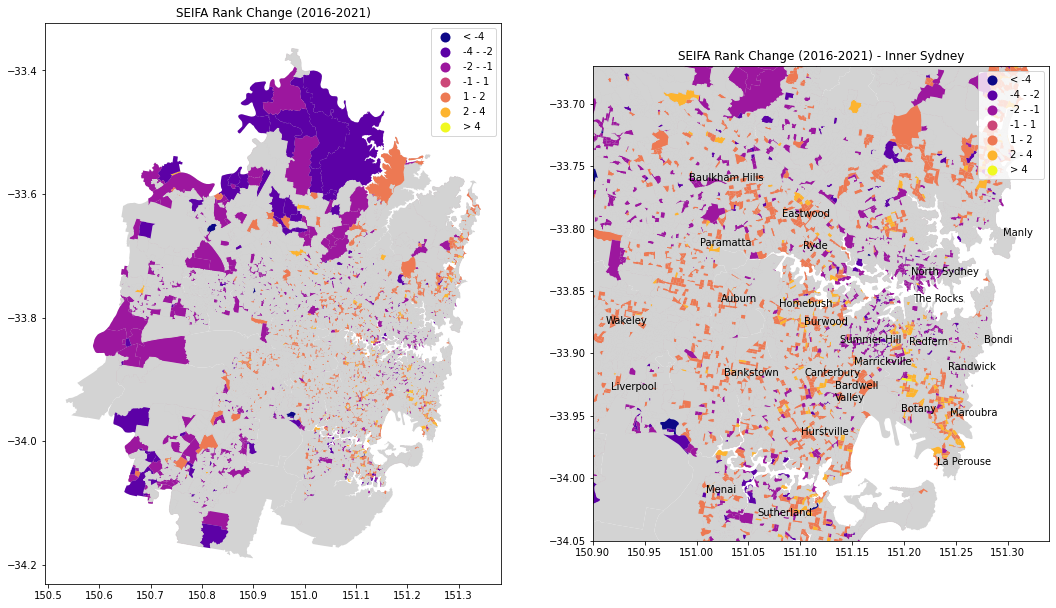

In [104]:
# Visualise SIEFA Rank Change coverage
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 12))

gdf_sa3_syd.plot(color='lightgrey', ax=axes[0])
sa1_xgb_syd.plot(column='SEIFA_bins', cmap="plasma", ax=axes[0], legend=True)
sa1_xgb_syd_sd1.plot(color='lightgrey', edgecolor='lightgrey', ax=axes[0])
ax=axes[0].set(title='SEIFA Rank Change (2016-2021)')

gdf_sa3_syd.plot(color='lightgrey', ax=axes[1])
sa1_xgb_syd.plot(column='SEIFA_bins', cmap="plasma", ax=axes[1], legend=True)
sa1_xgb_syd_sd1.plot(color='lightgrey', edgecolor='lightgrey', ax=axes[1])
ax=axes[1].set(title='SEIFA Rank Change (2016-2021) - Inner Sydney')
ax=axes[1].set_xlim([150.9, 151.34])
ax=axes[1].set_ylim([-34.05, -33.67])
ax=axes[1].text(151.152, -33.909, 'Marrickville'); ax=axes[1].text(151.277, -33.892, 'Bondi'); 
ax=axes[1].text(151.295, -33.806, 'Manly'); ax=axes[1].text(151.197, -33.947, 'Botany'); 
ax=axes[1].text(151.205, -33.893, 'Redfern'); ax=axes[1].text(151.133, -33.938, 'Bardwell\nValley');
ax=axes[1].text(151.104, -33.918, 'Canterbury'); ax=axes[1].text(151.103, -33.816, 'Ryde'); 
ax=axes[1].text(151.232, -33.989, 'La Perouse'); ax=axes[1].text(151.244, -33.950, 'Maroubra'); 
ax=axes[1].text(151.003, -33.814, 'Paramatta'); ax=axes[1].text(151.138, -33.892, 'Summer Hill'); 
ax=axes[1].text(151.059, -34.030, 'Sutherland'); ax=axes[1].text(151.101, -33.965, 'Hurstville'); 
ax=axes[1].text(150.918, -33.929, 'Liverpool'); ax=axes[1].text(151.207, -33.837, 'North Sydney'); 
ax=axes[1].text(151.009, -34.012, 'Menai'); ax=axes[1].text(150.993, -33.762, 'Baulkham Hills'); 
ax=axes[1].text(151.209, -33.859, 'The Rocks'); ax=axes[1].text(151.242, -33.913, 'Randwick');

ax=axes[1].text(151.026, -33.918, 'Bankstown'); ax=axes[1].text(151.0236, -33.859, 'Auburn');
ax=axes[1].text(151.082, -33.7904, 'Eastwood'); ax=axes[1].text(151.0796, -33.863, 'Homebush');
ax=axes[1].text(150.912, -33.876, 'Wakeley'); ax=axes[1].text(151.104, -33.877, 'Burwood');